# Heat equation

## imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.display import HTML
from scipy import special
import math

import seaborn as sns

## initialization

In [41]:
X_max = 100
Y_max = 120
X_min = Y_min = 0

NUMBER_X = 1000
NUMBER_Y = 1000

In [42]:
X_RANGE = np.linspace(X_min, X_max, NUMBER_X)
Y_RANGE = np.linspace(Y_min, Y_max, NUMBER_Y)

X_STEP = X_RANGE[1] - X_RANGE[0]
Y_STEP = Y_RANGE[1] - Y_RANGE[0]

In [43]:
X, Y = np.meshgrid(X_RANGE, Y_RANGE, indexing='ij')

T = np.zeros_like(X)
lambdas = np.ones_like(X)
source_c = np.zeros_like(X)
source_p = np.zeros_like(X)

In [44]:
alpha = np.zeros_like(X_RANGE)
beta = np.zeros_like(X_RANGE)

alpha[1] = 0

In [45]:
def calculate_coefficients(u, u_upper, u_lower, s, kind):
    """makes Thomas algorithm for longituginal and transversal kinds """
    if kind == 'longituginal':
        h_x = X_STEP
        h_y = Y_STEP
    elif kind == 'transversal':
        h_x = Y_STEP
        h_y = X_STEP
    
    a = b = h_y ** 2
    c = 2 * (h_x ** 2 + h_y ** 2)
    d = h_x ** 2 * (u_upper + u_lower) - s
    
    beta[1] = u[0]
    
    for i in range(1, len(u)-1):
        alpha[i+1] = b / (c - alpha[i] * a)
        beta[i+1] = (a * beta[i] + d[i]) / (c - alpha[i] * a)
    return alpha, beta
    
def thomas_algorithm(U, S, kind):
    
    if kind == 'transversal':
        U = U.transpose()
        
    for j in range(0, NUMBER_Y - 1):
        
        current_u = U[:, j]
        upper_u = U[:,j+1]
        lower_u = U[:,j-1]
        s = S[:, j]

        alpha, beta = calculate_coefficients(current_u, upper_u, lower_u, s, kind)

        for i in reversed(range(0, NUMBER_X - 1)):
            U[i, j+1] = alpha[i+1] * U[i+1, j+1] + beta[i+1]
            
    if kind == 'transversal':
        U = U.transpose()
            
    return U
    
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='hot')
    plt.colorbar()
    ax.invert_yaxis()

## boundary conditions

<img src="task3.png" height="100px" width="400px" >

In [93]:
lambda_edge = 10
T_edge = 300

### 1

In [94]:
size_x = int(10 / X_STEP)
size_y = int(10 / X_STEP)

lambdas[0 : size_x, 0 : size_y] = lambda_edge
T[0 : size_x, 0] = T_edge
T[0, 0 : size_y] = T_edge

## main procedure

In [95]:
check = True

In [96]:
while check:
    T_prev = T
    
    T = thomas_algorithm(T, source_c, 'longituginal')
    T = thomas_algorithm(T, source_c, 'transversal')
    
    T_difference = abs(T_prev - T)
    
    if np.amax(T_difference) < 0.1:
        check = False

## vizualization

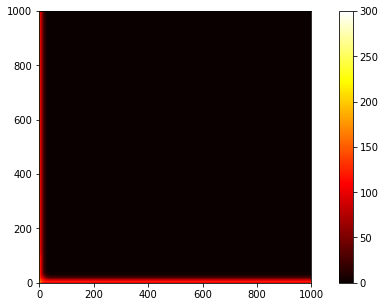

In [106]:
fig, ax = plt.subplots(figsize=(10,5))

heatmap2d(T)